# Text Analyses

In the basic analysis, we were able to gain a basic overview of the data package.  
With the following text analysis we want to compare how the history of the articles has affected the text. To do this, we compare the original version of the text (initial creation) with the most recently available version of the same article. 

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from bs4 import BeautifulSoup
import requests
import datetime
import re
import urllib
import shutil
import matplotlib.image as mpimg
import time
import crawlerlib as cl
import wikipedia
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('maxent_ne_chunker')
nltk.download('words')
import matplotlib as mpl

### Preparation

For our text analysis we have extended the crawlerlib with some functions: 
    getOldSoup: gets whole ur of the first version of a given wikipedia article with pagetitle
    getRecentSoup: gets whole ur of the recent version of a given wikipedia article with pagetitle
    getTextDF: gets original text and recent text of a given article
    getVD: gets vocabularity density for a given text
    getWPS: gets words per sentence for given text
    getWPT: gets words per text for given text
    tokenize: function to tokenize text
    untokenize: function to untokenize text
    equalize: funtion to equalize 2 texts
    insert_newlines: function to visualize comparison of texts human-readable
    show_comparison: tokenize, equalize and show comparison of texts

**Original Wiki-URL**

In this section, the function getOldSoup is used to get the link ot the first version of a wikipedia article.

In [2]:
def getOldSoup(wikititle):
	soup = requests.get("https://en.wikipedia.org/w/index.php?title="+wikititle+"&dir=prev&action=history")
	soup = BeautifulSoup(soup.content, 'html.parser')
	soup = soup.findAll("a", {"class": "mw-changeslist-date"})[0]['href']
	return 'https://en.wikipedia.org/'+soup

**Recent Wiki-URL**

In this section, the function getRecentSoup is used to get the link ot the most recent version of a wikipedia article.

In [3]:
def getRecentSoup(wikititle):
	wiki = 'https://en.wikipedia.org/wiki/'
	recent = wiki+wikititle
	return recent

**Wiki-Texts**

In This section the Text of the original article and the most recent articel is saved into a dataframe. This is done in order to compare changes in vocubalarity density, Words per Sentence and Words per text between different versions of the same article.

In [4]:
def getTextDF(urlis):
    textdf = pd.DataFrame(columns=['page_title', 'original', 'recent'])
    for i in range(len(urlis)):
        if str(getTextBody(urlis[i][0])).startswith('Redirect to'):
            continue
        else:
            s1 = str(getTextBody(urlis[i][0]))
            s2 = str(getTextBody(urlis[i][1]))
            textdf = textdf.append({'page_title' : str.rsplit(urlis[i][1], '/', 1)[-1], 'original' : s1, 'recent' : s2}, ignore_index=True)
    return textdf

**Vocabulary Density**

in this section, the vocabularity density of a given text is determined. For that, the number of unique words used in the text is divided by the total number of words in the text.

In [5]:
def getVD(text):
  tokens = nltk.word_tokenize(text)
  tagged = nltk.pos_tag(tokens)
  nn = []
  ok = 'NN' 
  for i in tagged:
    if ok == i[1]:
      nn.append(i[0])
  nn1 = [re.sub('[^a-zA-Z0-9]+', '', _) for _ in nn]
  nn2 = []
  for i in nn1:
    if len(i) > 2:
      nn2.append(i)
    else:
      nn2.append('no text')
  try:
    VD = len(np.unique(nn2)) / len(nn2)
  except ZeroDivisionError:
    VD = 1
  return VD

**Words per Sentence**

In this section, the number of words per sentence for a given text is determined. Therefore, a number of sentence ending characters are determined, and the sentences are divided into lists. From these sentences, the total number of words is calculated and then divided by the number of sentences.

In [6]:
def getWPS(text):
  tokens = nltk.word_tokenize(text)
  words = tokens
  sentences = [[]]
  ends = set(".?!;:")
  for word in words:
    if word in ends: 
      sentences.append([])
    else: 
      sentences[-1].append(word)
  if sentences[0]:
    if not sentences[-1]: sentences.pop()
    wps = sum(len(s) for s in sentences)/len(sentences)
    #print("average words per sentence: ", wps)
    return wps

**Words per Text**

In this section, the total number of words for a given sentence is determined. Therefore, the same function as above is taken, but is not divided by the number of sentences.

In [7]:
def getWPT(text):
    tokens = nltk.word_tokenize(text)
    words = tokens
    sentences = [[]]
    for word in words:
        sentences.append([word])
    wpt = len(sentences)
    return wpt

**Generating new DataFrame**

In [9]:
df = pd.read_csv('p1p857.csv', index_col=0)
df.head()

,page_id,page_title,revision_id,timestamp,comment,contributor_id,contributor_name,bytes,revtext,dates,times,revbytes,revperc
0,10,AccessibleComputing,233192,2001-01-21 02:12:21,*,99,RoseParks,124,This subject covers* AssistiveTechnology* Acce...,2001-01-21,02:12:21,2848,4.353933
1,10,AccessibleComputing,862220,2002-02-25 15:43:11,Automated conversion,1226483,Conversion script,35,#REDIRECT [[Accessible Computing]],2002-02-25,15:43:11,2848,1.228933
2,10,AccessibleComputing,15898945,2003-04-25 22:18:38,Fixing redirect,7543,Ams80,34,#REDIRECT [[Accessible_computing]],2003-04-25,22:18:38,2848,1.193820
3,10,AccessibleComputing,56681914,2006-06-03 16:55:41,fix double redirect,516514,Nzd,36,#REDIRECT [[Computer accessibility]],2006-06-03,16:55:41,2848,1.264045
4,10,AccessibleComputing,74466685,2006-09-08 04:16:04,cat rd,750223,Rory096,57,#REDIRECT [[Computer accessibility]] {{R from ...,2006-09-08,04:16:04,2848,2.001404


Taking a look at the Page Titles

In [10]:
titles = df['page_title'].unique()
titles[:100]

array(['AccessibleComputing', 'Anarchism', 'AfghanistanHistory',
       'AfghanistanGeography', 'AfghanistanPeople',
       'AfghanistanCommunications', 'AfghanistanTransportations',
       'AfghanistanMilitary', 'AfghanistanTransnationalIssues',
       'AssistiveTechnology', 'AmoeboidTaxa', 'Autism', 'AlbaniaHistory',
       'AlbaniaPeople', 'AsWeMayThink', 'AlbaniaGovernment',
       'AlbaniaEconomy', 'Albedo', 'AfroAsiaticLanguages',
       'ArtificalLanguages', 'AbacuS', 'AbalonE', 'AbbadideS', 'AbbesS',
       'AbbevilleFrance', 'AbbeY', 'AbboT', 'Abbreviations',
       'AtlasShrugged', 'ArtificialLanguages', 'AtlasShruggedCharacters',
       'AtlasShruggedCompanies', 'AyersMusicPublishingCompany',
       'Talk:Atlas Shrugged', 'AfricanAmericanPeople', 'AdolfHitler',
       'AbeceDarians', 'AbeL', 'AbensbergGermany', 'AberdeenSouthDakota',
       'ArthurKoestler', 'AynRand', 'AlexanderTheGreat',
       'AnchorageAlaska', 'ArgumentForms',
       'ArgumentsForTheExistenceOfGod', 'An

get URLs of original and recent textversion of every article in the df

Here the URLS of both the original versions and the most recent versions for every article in our df are saved into separate lists. They will afterwards be stored as tuples in a list, where one tuple has both the original and recent URLS of an article. 

In [11]:
original = []
recent = []

for i in df['page_title'].unique():
    original.append(getOldSoup(i))
    recent.append(getRecentSoup(i))

In [12]:
urlis = list(zip(original, recent))

Now, a new dataframe is defined, with the title of every page, as well as both original and most recent texts.

In [13]:
textdf = cl.getTextDF(urlis)

In [14]:
textdf.head()

,page_title,original,recent
0,Anarchism,Anarchism is a name taken by various political...,"For other uses,see Anarchism (disambiguation)...."
1,Autism,Autism is a complex pervasive developmental di...,This article is about the classic autistic dis...
2,Albedo,"In climatology,the albedo of a surface is the ...","For other uses,see Albedo (disambiguation).The..."
3,Talk:Atlas Shrugged,Cleanup&lt;/ 1 Cleanup2 Bias of 'Influences a...,class=ext-discussiontools-init-sectionExtern...
4,A,The letter A is the first letter in the Roman ...,This article is about the Roman letter.For oth...


Afterwards all Page titles containing the strings "talk" or "user are removed. Those are discussion pages and not actual articles. Also, all Pages with the name "disambiguation" are removed, because those pages just reference other pages, and don't contain actual information.

In [15]:
filter = (~textdf['page_title'].str.contains('^Talk:')) & (~textdf['page_title'].str.contains('^User:')) & (~textdf['page_title'].str.contains('disambiguation'))

In [16]:
textdf1 = textdf[filter]
textdf1.head()

,page_title,original,recent
0,Anarchism,Anarchism is a name taken by various political...,"For other uses,see Anarchism (disambiguation)...."
1,Autism,Autism is a complex pervasive developmental di...,This article is about the classic autistic dis...
2,Albedo,"In climatology,the albedo of a surface is the ...","For other uses,see Albedo (disambiguation).The..."
4,A,The letter A is the first letter in the Roman ...,This article is about the Roman letter.For oth...
6,Alabama,Alternate meanings: See Alabama (disambiguatio...,This article is about the U.S.state.For the ri...


Then, the list is checked if all "old" entries are removed (written without space) and how many different pages are still left in the dataframe.

In [17]:
print( 'entries: ', len(textdf['page_title']), '\n', textdf1['page_title'].unique()[:10], '...')

entries:  160 
 ['Anarchism' 'Autism' 'Albedo' 'A' 'Alabama' 'Achilles' 'Abraham Lincoln'
 'Aristotle' 'An American in Paris'
 'Academy Award for Best Production Design'] ...


create new columns with VD of old entries and VD of recent entries

Now a couple of columns are added to the dataframe: first of all, new columns in the dataframe are created, which will provide Vocabularity Density for both versions of all articles. But before that can be done, two lists with vocabularity densities for every article are filled with values for either the first or the most recent article, before they are appended to the dataframe.

In [18]:
originalVD = []

for i in textdf1['original']:
    originalVD.append(getVD(i))

In [19]:
recentVD = []

for i in textdf1['recent']:
    recentVD.append(getVD(i))

In [20]:
VDs = list(zip(originalVD, recentVD))
VDs[:10]

[(0.6679389312977099, 0.4892550143266476),
 (0.3984375, 0.4991896272285251),
 (0.5688888888888889, 0.4405940594059406),
 (0.5380710659898477, 0.47191011235955055),
 (0.6388888888888888, 0.4564404061998931),
 (0.6948051948051948, 0.5503626107977437),
 (0.4174454828660436, 0.5529847292919945),
 (0.6317135549872123, 0.4977416440831075),
 (0.9090909090909091, 0.6476868327402135),
 (0.8488372093023255, 0.8636363636363636)]

In [21]:
textdf1['originalVD'] = originalVD

<ipython-input-21-a67e8c74a7c3>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  textdf1['originalVD'] = originalVD


In [22]:
textdf1['recentVD'] = recentVD

<ipython-input-22-ca01994fcacd>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  textdf1['recentVD'] = recentVD


In [23]:
textdf1.head()

,page_title,original,recent,originalVD,recentVD
0,Anarchism,Anarchism is a name taken by various political...,"For other uses,see Anarchism (disambiguation)....",0.667939,0.489255
1,Autism,Autism is a complex pervasive developmental di...,This article is about the classic autistic dis...,0.398438,0.499190
2,Albedo,"In climatology,the albedo of a surface is the ...","For other uses,see Albedo (disambiguation).The...",0.568889,0.440594
4,A,The letter A is the first letter in the Roman ...,This article is about the Roman letter.For oth...,0.538071,0.471910
6,Alabama,Alternate meanings: See Alabama (disambiguatio...,This article is about the U.S.state.For the ri...,0.638889,0.456440


Second of all, columns for Words per Text for each version of each article are appended. They are also stored in lists, before they are passed onto the Dataframe.

In [24]:
originalWPT = []

for i in textdf1['original']:
    originalWPT.append(getWPT(i))

In [25]:
recentWPT = []

for i in textdf1['recent']:
    recentWPT.append(getWPT(i))

In [26]:
textdf1['originalWPT'] = originalWPT
textdf1['recentWPT'] = recentWPT

<ipython-input-26-b8b74676b60a>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  textdf1['originalWPT'] = originalWPT
<ipython-input-26-b8b74676b60a>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  textdf1['recentWPT'] = recentWPT


In [27]:
textdf1.head()

,page_title,original,recent,originalVD,recentVD,originalWPT,recentWPT
0,Anarchism,Anarchism is a name taken by various political...,"For other uses,see Anarchism (disambiguation)....",0.667939,0.489255,1733,10518
1,Autism,Autism is a complex pervasive developmental di...,This article is about the classic autistic dis...,0.398438,0.499190,857,7320
2,Albedo,"In climatology,the albedo of a surface is the ...","For other uses,see Albedo (disambiguation).The...",0.568889,0.440594,1426,4152
4,A,The letter A is the first letter in the Roman ...,This article is about the Roman letter.For oth...,0.538071,0.471910,1527,2386
6,Alabama,Alternate meanings: See Alabama (disambiguatio...,This article is about the U.S.state.For the ri...,0.638889,0.456440,491,13683


Thereafter, two new columns in the Dataframe are created, which will store the Numbers for each versions Words ber sentence.

In [28]:
originalWPS = []

for i in textdf1['original']:
    originalWPS.append(getWPS(i))

In [29]:
recentWPS = []

for i in textdf1['recent']:
    recentWPS.append(getWPS(i))

In [30]:
textdf1['originalWPS'] = originalWPS
textdf1['recentWPS'] = recentWPS

<ipython-input-30-55e95f3d2836>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  textdf1['originalWPS'] = originalWPS
<ipython-input-30-55e95f3d2836>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  textdf1['recentWPS'] = recentWPS


In [31]:
textdf1.head()

,page_title,original,recent,originalVD,recentVD,originalWPT,recentWPT,originalWPS,recentWPS
0,Anarchism,Anarchism is a name taken by various political...,"For other uses,see Anarchism (disambiguation)....",0.667939,0.489255,1733,10518,32.326923,25.161692
1,Autism,Autism is a complex pervasive developmental di...,This article is about the classic autistic dis...,0.398438,0.499190,857,7320,25.781250,84.116279
2,Albedo,"In climatology,the albedo of a surface is the ...","For other uses,see Albedo (disambiguation).The...",0.568889,0.440594,1426,4152,51.777778,152.777778
4,A,The letter A is the first letter in the Roman ...,This article is about the Roman letter.For oth...,0.538071,0.471910,1527,2386,33.681818,25.208791
6,Alabama,Alternate meanings: See Alabama (disambiguatio...,This article is about the U.S.state.For the ri...,0.638889,0.456440,491,13683,13.441176,93.358621


Next are the total number of revisions per Wikipedia article. These values will be stored in a single column, and will later be used to analyse the article.

In [32]:
textdf2 = pd.merge(textdf1, df.groupby(['page_title']).agg({'revision_id' : 'count'}).reset_index(), how='left')
textdf2.head()

,page_title,original,recent,originalVD,recentVD,originalWPT,recentWPT,originalWPS,recentWPS,revision_id
0,Anarchism,Anarchism is a name taken by various political...,"For other uses,see Anarchism (disambiguation)....",0.667939,0.489255,1733,10518,32.326923,25.161692,19961.0
1,Autism,Autism is a complex pervasive developmental di...,This article is about the classic autistic dis...,0.398438,0.499190,857,7320,25.781250,84.116279,10646.0
2,Albedo,"In climatology,the albedo of a surface is the ...","For other uses,see Albedo (disambiguation).The...",0.568889,0.440594,1426,4152,51.777778,152.777778,1253.0
3,A,The letter A is the first letter in the Roman ...,This article is about the Roman letter.For oth...,0.538071,0.471910,1527,2386,33.681818,25.208791,4802.0
4,Alabama,Alternate meanings: See Alabama (disambiguatio...,This article is about the U.S.state.For the ri...,0.638889,0.456440,491,13683,13.441176,93.358621,10202.0


Afterwards, a column with the number of unique contributors, who worked on each article, is added.

In [33]:
textdf3 = pd.merge(textdf2, df.groupby(['page_title']).agg({'contributor_id' : pd.Series.nunique}).reset_index(), how='left')
textdf3.head()

,page_title,original,recent,originalVD,recentVD,originalWPT,recentWPT,originalWPS,recentWPS,revision_id,contributor_id
0,Anarchism,Anarchism is a name taken by various political...,"For other uses,see Anarchism (disambiguation)....",0.667939,0.489255,1733,10518,32.326923,25.161692,19961.0,3797.0
1,Autism,Autism is a complex pervasive developmental di...,This article is about the classic autistic dis...,0.398438,0.499190,857,7320,25.781250,84.116279,10646.0,3757.0
2,Albedo,"In climatology,the albedo of a surface is the ...","For other uses,see Albedo (disambiguation).The...",0.568889,0.440594,1426,4152,51.777778,152.777778,1253.0,701.0
3,A,The letter A is the first letter in the Roman ...,This article is about the Roman letter.For oth...,0.538071,0.471910,1527,2386,33.681818,25.208791,4802.0,2609.0
4,Alabama,Alternate meanings: See Alabama (disambiguatio...,This article is about the U.S.state.For the ri...,0.638889,0.456440,491,13683,13.441176,93.358621,10202.0,4485.0


In addition to the unique number of contributors of an article, there is also a column for the number of unique contributor names. This should give an insight on how many people worked on an article as anonymous.

In [34]:
textdf4 = pd.merge(textdf3, df.groupby(['page_title']).agg({'contributor_name' : pd.Series.nunique}).reset_index(), how='left')
textdf4.head()

,page_title,original,recent,originalVD,recentVD,originalWPT,recentWPT,originalWPS,recentWPS,revision_id,contributor_id,contributor_name
0,Anarchism,Anarchism is a name taken by various political...,"For other uses,see Anarchism (disambiguation)....",0.667939,0.489255,1733,10518,32.326923,25.161692,19961.0,3797.0,1918.0
1,Autism,Autism is a complex pervasive developmental di...,This article is about the classic autistic dis...,0.398438,0.499190,857,7320,25.781250,84.116279,10646.0,3757.0,1885.0
2,Albedo,"In climatology,the albedo of a surface is the ...","For other uses,see Albedo (disambiguation).The...",0.568889,0.440594,1426,4152,51.777778,152.777778,1253.0,701.0,448.0
3,A,The letter A is the first letter in the Roman ...,This article is about the Roman letter.For oth...,0.538071,0.471910,1527,2386,33.681818,25.208791,4802.0,2609.0,1448.0
4,Alabama,Alternate meanings: See Alabama (disambiguatio...,This article is about the U.S.state.For the ri...,0.638889,0.456440,491,13683,13.441176,93.358621,10202.0,4485.0,2260.0


Next, a new column is added to show the unique number of days an article was worked on.

In [35]:
textdf5 = pd.merge(textdf4, df.groupby(['page_title']).agg({'dates' : pd.Series.nunique}).reset_index(), how='left')
textdf5.head()

,page_title,original,recent,originalVD,recentVD,originalWPT,recentWPT,originalWPS,recentWPS,revision_id,contributor_id,contributor_name,dates
0,Anarchism,Anarchism is a name taken by various political...,"For other uses,see Anarchism (disambiguation)....",0.667939,0.489255,1733,10518,32.326923,25.161692,19961.0,3797.0,1918.0,3216.0
1,Autism,Autism is a complex pervasive developmental di...,This article is about the classic autistic dis...,0.398438,0.499190,857,7320,25.781250,84.116279,10646.0,3757.0,1885.0,2537.0
2,Albedo,"In climatology,the albedo of a surface is the ...","For other uses,see Albedo (disambiguation).The...",0.568889,0.440594,1426,4152,51.777778,152.777778,1253.0,701.0,448.0,731.0
3,A,The letter A is the first letter in the Roman ...,This article is about the Roman letter.For oth...,0.538071,0.471910,1527,2386,33.681818,25.208791,4802.0,2609.0,1448.0,1489.0
4,Alabama,Alternate meanings: See Alabama (disambiguatio...,This article is about the U.S.state.For the ri...,0.638889,0.456440,491,13683,13.441176,93.358621,10202.0,4485.0,2260.0,3119.0


Finally, there are two new columns regarding revised bytes, that were added. The first column shows the raw bytes, and was created by filtering the original dataframe. Afterwards, it was merged with the new dataframe. Becaus the number is hard to read, the second column shows the amount of revised bytes in Gigabyte.

In [36]:
df1 = df.drop_duplicates(subset='revbytes', keep="first", inplace=False)
df1.head()

,page_id,page_title,revision_id,timestamp,comment,contributor_id,contributor_name,bytes,revtext,dates,times,revbytes,revperc
0,10,AccessibleComputing,233192,2001-01-21 02:12:21,*,99,RoseParks,124,This subject covers* AssistiveTechnology* Acce...,2001-01-21,02:12:21,2848,4.353933
14,12,Anarchism,18201,2002-02-25 15:00:22,Automated conversion,1226483,Conversion script,9546,[[talk:Anarchism/Talk]] <br>[[Anarchism/Todo/T...,2002-02-25,15:00:22,1689954733,0.000565
19975,13,AfghanistanHistory,176453,2002-02-25 15:43:11,Automated conversion,1226483,Conversion script,34,#REDIRECT [[Afghanistan/History]],2002-02-25,15:43:11,787,4.320203
19981,14,AfghanistanGeography,233198,2001-01-21 23:00:32,*,32609824,LinusTolke,1663,"Irrigated land: 30,000 sq km (1993 est.) Natur...",2001-01-21,23:00:32,1988,83.651911
19988,15,AfghanistanPeople,133439,2002-02-25 15:43:11,Automated conversion,1226483,Conversion script,33,#REDIRECT [[Afghanistan/People]],2002-02-25,15:43:11,1993,1.655795


In [37]:
textdf6 = pd.merge(textdf5, df1[['page_title', 'revbytes']], on='page_title', how='left')
textdf6.head()

,page_title,original,recent,originalVD,recentVD,originalWPT,recentWPT,originalWPS,recentWPS,revision_id,contributor_id,contributor_name,dates,revbytes
0,Anarchism,Anarchism is a name taken by various political...,"For other uses,see Anarchism (disambiguation)....",0.667939,0.489255,1733,10518,32.326923,25.161692,19961.0,3797.0,1918.0,3216.0,1.689955e+09
1,Autism,Autism is a complex pervasive developmental di...,This article is about the classic autistic dis...,0.398438,0.499190,857,7320,25.781250,84.116279,10646.0,3757.0,1885.0,2537.0,9.503834e+08
2,Albedo,"In climatology,the albedo of a surface is the ...","For other uses,see Albedo (disambiguation).The...",0.568889,0.440594,1426,4152,51.777778,152.777778,1253.0,701.0,448.0,731.0,3.025434e+07
3,A,The letter A is the first letter in the Roman ...,This article is about the Roman letter.For oth...,0.538071,0.471910,1527,2386,33.681818,25.208791,4802.0,2609.0,1448.0,1489.0,4.717380e+07
4,Alabama,Alternate meanings: See Alabama (disambiguatio...,This article is about the U.S.state.For the ri...,0.638889,0.456440,491,13683,13.441176,93.358621,10202.0,4485.0,2260.0,3119.0,1.130464e+09


In [38]:
textdf6['revgb'] = textdf6['revbytes']/1e+9
textdf6.head()

,page_title,original,recent,originalVD,recentVD,originalWPT,recentWPT,originalWPS,recentWPS,revision_id,contributor_id,contributor_name,dates,revbytes,revgb
0,Anarchism,Anarchism is a name taken by various political...,"For other uses,see Anarchism (disambiguation)....",0.667939,0.489255,1733,10518,32.326923,25.161692,19961.0,3797.0,1918.0,3216.0,1.689955e+09,1.689955
1,Autism,Autism is a complex pervasive developmental di...,This article is about the classic autistic dis...,0.398438,0.499190,857,7320,25.781250,84.116279,10646.0,3757.0,1885.0,2537.0,9.503834e+08,0.950383
2,Albedo,"In climatology,the albedo of a surface is the ...","For other uses,see Albedo (disambiguation).The...",0.568889,0.440594,1426,4152,51.777778,152.777778,1253.0,701.0,448.0,731.0,3.025434e+07,0.030254
3,A,The letter A is the first letter in the Roman ...,This article is about the Roman letter.For oth...,0.538071,0.471910,1527,2386,33.681818,25.208791,4802.0,2609.0,1448.0,1489.0,4.717380e+07,0.047174
4,Alabama,Alternate meanings: See Alabama (disambiguatio...,This article is about the U.S.state.For the ri...,0.638889,0.456440,491,13683,13.441176,93.358621,10202.0,4485.0,2260.0,3119.0,1.130464e+09,1.130464


Now we start to explore and visualize the data: we can plot the vocabularity density, words per text and words per sentence and can have a look, how all the articles have evolved. Inthis case we used histograms. On the x- axis, we have the indvidual scores for each of the three sections, we wanted to explore (Vocabularity Density from 0 to 1; words per Sentence from 0 to 400; Words per Text from 0 25000), while on the y- axis, the number of articles for each category is displayed.

We also had a look on a correlation matrix, in order to see if certain sections of our analysis correlate to other ones. While most of those sections don't really correlate with the others, there are a few that lokk like they would correlate.

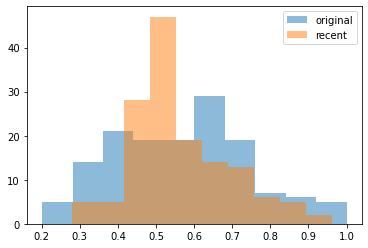

In [39]:
plt.hist(np.sort(textdf6['originalVD']), alpha = 0.5, label = 'original')
plt.hist(np.sort(textdf6['recentVD']), alpha = 0.5, label = 'recent')
plt.legend()

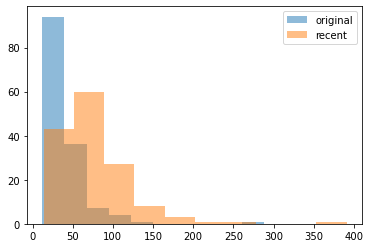

In [40]:
plt.hist(np.sort(textdf6['originalWPS']), alpha = 0.5, label = 'original')
plt.hist(np.sort(textdf6['recentWPS']), alpha = 0.5, label = 'recent')
plt.legend()

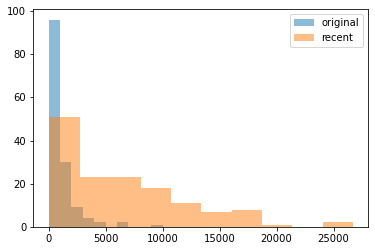

In [41]:
plt.hist(np.sort(textdf6['originalWPT']), alpha = 0.5, label = 'original')
plt.hist(np.sort(textdf6['recentWPT']), alpha = 0.5, label = 'recent')
plt.legend()

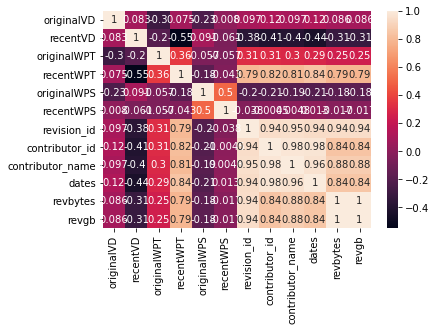

In [42]:
corrMatrix = textdf6.corr()
sns.heatmap(corrMatrix, annot=True)
plt.show()